In [15]:
import pandas as pd
import functionwords
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random 
from tqdm import tqdm
import statsmodels.api as sm

In [7]:
root = "/shared/3/projects/benlitterer/podcastData/diarizationMerged/"
pathList = []
for path, subdirs, files in os.walk(root):
    for name in files:
        pathList.append(os.path.join(path, name))

In [10]:
paths = random.sample(pathList, 1000)

In [157]:
stem = "/shared/3/projects/benlitterer/podcastData/diarizationMerged/anchor.fm/02/"
#testPaths = os.listdir(stem)[:300]

In [77]:
def getTurnDf(inDf): 
    #create a list of tuples where we have the text, the prev and current speaker as a string and then whatever other features we might want 
    prevSpeakList = []
    featureNames = ["content", "mfcc1_sma3", "mfcc2_sma3", "mfcc3_sma3", "mfcc4_sma3", "F0semitoneFrom27.5Hz_sma3nz", "F1frequency_sma3nz"]

    #the beginning is for content the end is for 
    prevData = [""] + [0 for i in range(1, len(featureNames)+1)]
    currData = [""] + [0 for i in range(1, len(featureNames)+1)]
    turnCount = 0 
    tupList = []
    for i, row in inDf.iterrows(): 
        speakList = row["speakers"]

        #if someone is speaking now and someone was speaking before 
        if len(speakList) > 0 and len(prevSpeakList) > 0: 
            
            #here we always use person who was "interrupted" by other speaker
            #i.e. was already speaking 
            currSpeaker = speakList[0]
            prevSpeaker = prevSpeakList[0]

            #if we have a speaker change 
            if currSpeaker != prevSpeaker:
                #only if there's something to append 
                #TODO: revisit if this is the preferred way to do this 
                if len(currData[0]) > 0:  
                    #we want the mean of the prosodic features within speaker turns 
                    currData =  [currData[0]] + [item/currData[-1] for item in currData[1:-1]] + [currData[-1]]
                    tupList.append(prevData + currData + [prevSpeaker, currSpeaker, turnCount])
                    turnCount += 1
                    prevData = currData
                else: 
                    prevData = [""] + [0 for i in range(1, len(featureNames)+1)]
                currData = [""] + [0 for i in range(1, len(featureNames)+1)]

        #get the current content 
        content = row["content"]
        
        #we only consider when we have speakers associated with text 
        #just skip if we don't 
        if len(speakList) > 0: 
            prevSpeakList = speakList
        
            if content == content and content != None: 
                currData[0] += row["content"] 
            
            for i in range(1, len(featureNames)): 
                currFeature = row[featureNames[i]]
                currData[i] += currFeature
            
            #this tracks how many times we've added to the feature vector
            currData[-1] += 1

    return tupList

In [70]:
[1, 2, 3, 4,5][1:-1]

[2, 3, 4]

In [76]:
#currDf = pd.read_json(paths[4], orient="records", lines=True)
#getTurnDf(currDf)

In [78]:
allTups = []

for path in tqdm(paths): 
    path

    #just want to load in an example file here 
    currDf = pd.read_json(path, orient="records", lines=True)


    currTups = getTurnDf(currDf)
    allTups = allTups + currTups
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:53<00:00,  2.42it/s]


In [81]:
allTups[0]

['',
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 ' [Music [Music] [Music] [Music] [Music] [Music',
 19.60536682234118,
 1.942528111488235,
 11.786359194476471,
 4.030576062194117,
 17.79852393359412,
 584.7684199277118,
 17,
 'SPEAKER_01',
 'SPEAKER_00',
 0]

In [83]:
from functionwords import FunctionWords
fw = FunctionWords(function_words_list="english")


featureNames = ["content", "mfcc1_sma3", "mfcc2_sma3", "mfcc3_sma3", "mfcc4_sma3", "F0semitoneFrom27.5Hz_sma3nz", "F1frequency_sma3nz"]
colNames = ["a_" + featureName for featureName in featureNames] + ["a_tokenCount"] + ["b_" + featureName for featureName in featureNames] + ["b_tokenCount", "speakerA",  "speakerB", "turnCount"]
turnDf = pd.DataFrame(allTups, columns=colNames)


In [84]:
turnDf.head() 

,a_content,a_mfcc1_sma3,a_mfcc2_sma3,a_mfcc3_sma3,a_mfcc4_sma3,a_F0semitoneFrom27.5Hz_sma3nz,a_F1frequency_sma3nz,a_tokenCount,b_content,b_mfcc1_sma3,b_mfcc2_sma3,b_mfcc3_sma3,b_mfcc4_sma3,b_F0semitoneFrom27.5Hz_sma3nz,b_F1frequency_sma3nz,b_tokenCount,speakerA,speakerB,turnCount
0,,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,[Music [Music] [Music] [Music] [Music] [Music,19.605367,1.942528,11.786359,4.030576,17.798524,584.768420,17,SPEAKER_01,SPEAKER_00,0
1,[Music [Music] [Music] [Music] [Music] [Music,19.605367,1.942528,11.786359,4.030576,17.798524,584.768420,17,],21.953674,-1.450533,4.584490,0.840227,17.712638,451.538066,1,SPEAKER_00,SPEAKER_01,1
2,],21.953674,-1.450533,4.584490,0.840227,17.712638,451.538066,1,[Music] [Music] [Music,20.267963,-2.537376,11.108616,3.705092,18.328890,576.768528,9,SPEAKER_01,SPEAKER_00,2
3,[Music] [Music] [Music,20.267963,-2.537376,11.108616,3.705092,18.328890,576.768528,9,] [,22.456248,2.002700,14.681385,-0.415404,8.662306,655.344522,3,SPEAKER_00,SPEAKER_01,3
4,] [,22.456248,2.002700,14.681385,-0.415404,8.662306,655.344522,3,MusicMusic]Music [Music [Music] [Music] [Music] [,19.789462,3.690596,7.433048,3.998432,14.638941,641.657530,17,SPEAKER_01,SPEAKER_00,4


In [86]:
turnDf["a_fwCount"] = turnDf["a_content"].apply(lambda x: sum(fw.transform(x)))
turnDf["b_fwCount"] = turnDf["b_content"].apply(lambda x: sum(fw.transform(x)))

In [ ]:
turnDf.shape

(89439, 8)

,a_content,a_mfcc1_sma3,a_mfcc2_sma3,a_mfcc3_sma3,a_mfcc4_sma3,a_F0semitoneFrom27.5Hz_sma3nz,a_F1frequency_sma3nz,a_tokenCount,b_content,b_mfcc1_sma3,...,b_mfcc3_sma3,b_mfcc4_sma3,b_F0semitoneFrom27.5Hz_sma3nz,b_F1frequency_sma3nz,b_tokenCount,speakerA,speakerB,turnCount,a_fwCount,b_fwCount
0,,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,[Music [Music] [Music] [Music] [Music] [Music,19.605367,...,11.786359,4.030576,17.798524,584.768420,17,SPEAKER_01,SPEAKER_00,0,0,0
1,[Music [Music] [Music] [Music] [Music] [Music,19.605367,1.942528,11.786359,4.030576,17.798524,584.768420,17,],21.953674,...,4.584490,0.840227,17.712638,451.538066,1,SPEAKER_00,SPEAKER_01,1,0,0
2,],21.953674,-1.450533,4.584490,0.840227,17.712638,451.538066,1,[Music] [Music] [Music,20.267963,...,11.108616,3.705092,18.328890,576.768528,9,SPEAKER_01,SPEAKER_00,2,0,0
3,[Music] [Music] [Music,20.267963,-2.537376,11.108616,3.705092,18.328890,576.768528,9,] [,22.456248,...,14.681385,-0.415404,8.662306,655.344522,3,SPEAKER_00,SPEAKER_01,3,0,0
4,] [,22.456248,2.002700,14.681385,-0.415404,8.662306,655.344522,3,MusicMusic]Music [Music [Music] [Music] [Music] [,19.789462,...,7.433048,3.998432,14.638941,641.657530,17,SPEAKER_01,SPEAKER_00,4,0,0


In [71]:
#grouped = turnDf.groupby(by=["aLabel", "bLabel"]).agg(list)
#grouped["turnCounts"] = grouped["bFwCount"].apply(len)
#grouped = grouped.sort_values("turnCounts", ascending=False)

In [72]:
#grouped["correlations"] = grouped.apply(lambda row: np.corrcoef(row["aFwCount"], row["bFwCount"])[1,0], axis=1)

/opt/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [91]:
#regDf = grouped.explode(["aContent", "bContent", "aFwCount", "bFwCount"])
#regDf = regDf[regDf["turnCounts"] > 20]

In [87]:
regDf = turnDf
regDf["a_fwCount"] = regDf["a_fwCount"].astype(int)
regDf["b_fwCount"] = regDf["b_fwCount"].astype(int)

In [107]:

regDf = regDf[(regDf["a_tokenCount"] > 10) & (regDf["b_tokenCount"] > 10)]

In [108]:
regDf.shape

(34434, 23)

/opt/anaconda/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(0.0, 50.0)

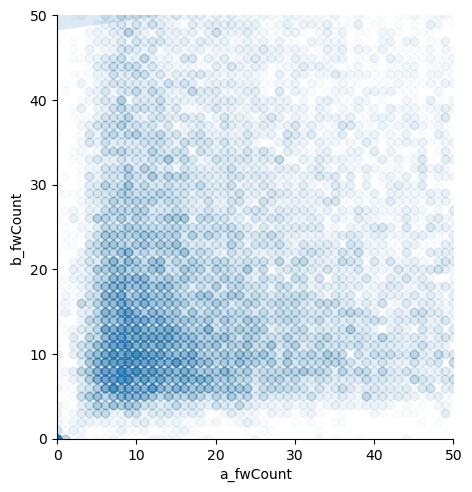

In [109]:
#TODO: deal with zero inflation
sns.lmplot(data=regDf, x="a_fwCount", y="b_fwCount", scatter_kws={"alpha":.025})
plt.xlim(0, 50)
plt.ylim(0, 50)

In [114]:
regDf["aWC"] = regDf["a_content"].apply(lambda x: len(x.split()))
regDf["bWC"] = regDf["b_content"].apply(lambda x: len(x.split()))

/tmp/ipykernel_2756260/3086644992.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regDf["aWC"] = regDf["a_content"].apply(lambda x: len(x.split()))
/tmp/ipykernel_2756260/3086644992.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regDf["bWC"] = regDf["b_content"].apply(lambda x: len(x.split()))


In [115]:
X = regDf[["a_fwCount", "aWC", "bWC"]].to_numpy()
X = sm.add_constant(X)

In [116]:
y = np.array(regDf["b_fwCount"])

#now let's try a regression? 
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 1.321e+06
Date:                Thu, 02 May 2024   Prob (F-statistic):               0.00
Time:                        13:34:47   Log-Likelihood:            -1.3607e+05
No. Observations:               34434   AIC:                         2.721e+05
Df Residuals:                   34430   BIC:                         2.722e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2029      0.080     15.062      0.0

In [118]:
regDf = regDf.dropna() 
regDf.shape

(34431, 23)

In [120]:
regDf.head() 

,a_content,a_mfcc1_sma3,a_mfcc2_sma3,a_mfcc3_sma3,a_mfcc4_sma3,a_F0semitoneFrom27.5Hz_sma3nz,a_F1frequency_sma3nz,a_tokenCount,b_content,b_mfcc1_sma3,...,b_F0semitoneFrom27.5Hz_sma3nz,b_F1frequency_sma3nz,b_tokenCount,speakerA,speakerB,turnCount,a_fwCount,b_fwCount,aWC,bWC
17,finish that bottle that in stage three should...,30.625115,8.951356,26.414527,2.845596,13.772162,632.911519,24,well we've got we're only about a minute and ...,31.853913,...,14.528866,645.294938,89,SPEAKER_02,SPEAKER_03,3,13,45,23,80
18,well we've got we're only about a minute and ...,31.853913,11.152916,16.548932,9.355214,14.528866,645.294938,89,buy something if it's a little fashion grandm...,27.248248,...,13.095051,690.953107,12,SPEAKER_03,SPEAKER_02,4,45,7,80,10
19,buy something if it's a little fashion grandm...,27.248248,9.972305,21.238163,5.818431,13.095051,690.953107,12,cookies I just was thinking that my mind and ...,31.579067,...,14.903157,638.701785,63,SPEAKER_02,SPEAKER_03,5,7,42,10,56
20,cookies I just was thinking that my mind and ...,31.579067,11.034298,16.052070,6.048378,14.903157,638.701785,63,you go that it done there you go what a fucki...,31.599288,...,12.964303,642.753105,20,SPEAKER_03,SPEAKER_02,6,42,12,56,19
21,you go that it done there you go what a fucki...,31.599288,6.650945,22.698074,4.275955,12.964303,642.753105,20,the sound of anything reminiscent of the old ...,26.395403,...,13.828746,650.889167,11,SPEAKER_02,SPEAKER_03,7,12,5,19,11


In [122]:

def getFeatureReg(featureName): 
    currDf = regDf
    currDf["WCInter"] = currDf["bWC"] * currDf[f"b_{featureName}"]
    X = currDf[[f"a_{featureName}", "bWC", "WCInter"]].to_numpy()
    X = sm.add_constant(X)

    y = np.array(regDf[f"b_{featureName}"])


    #now let's try a regression? 
    model = sm.OLS(y, X)
    results = model.fit()
    print(results.summary())

for featureName in featureNames[1:]: 
    getFeatureReg(featureName)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     4687.
Date:                Thu, 02 May 2024   Prob (F-statistic):               0.00
Time:                        13:45:45   Log-Likelihood:            -1.0909e+05
No. Observations:               34431   AIC:                         2.182e+05
Df Residuals:                   34427   BIC:                         2.182e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.9552      0.110    135.908      0.0

In [ ]:

X = pitchDf[["a_F0semitoneFrom27.5Hz_sma3nz"]].to_numpy()
X = sm.add_constant(X)

y = np.array(pitchDf["b_F0semitoneFrom27.5Hz_sma3nz"])


#now let's try a regression? 
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

In [78]:

def computeLinReg(aFwCount, bFwCount):
    y = aFwCount
    X = np.array(bFwCount)
    X = sm.add_constant(X)

aFwCount = grouped.iloc[0]["aFwCount"]
bFwCount = grouped.iloc[0]["bFwCount"]
y = np.array(aFwCount)
X = np.array(bFwCount)
X = sm.add_constant(X)


In [79]:
y

array([  0,   7,  64,   4,   5,  58,  65,   1,  86,   1, 112,  13, 165,
        14, 295,   9, 332, 128,   2, 142, 104,  38,   1,   4,   4,   2,
       280,  69,   1,   0,   1,  64,  10,  46,   2,   3,   0,   2, 112,
         0,   0, 139,  13,   4, 139,  20, 133,  35,   0,   9, 217,  66,
         3,  27,  17,  70,  49, 123, 178,   1,   1,   0, 346,   7,  66,
         4,   1, 118,   0,  26,   0,   3,   1,   1,   0,  63,  25,  11,
         2,  90,   1,  61,  15,   6,   2,   9,   1,   1,   1,  13,  11,
         0,  84,   0,   0])

In [89]:
grouped.head() 

aContent  \
aLabel     bLabel                                                          
SPEAKER_01 SPEAKER_05  [Music, , Michael. I'm really excited to be he...   
SPEAKER_05 SPEAKER_01  [ Welcome to NBA Without BS, where I speak wit...   
SPEAKER_03 SPEAKER_05  [ okay. So, I think get on podcasts is really ...   
SPEAKER_05 SPEAKER_03  [ on one or for getting on one. Oh,,  Not, 't ...   
           SPEAKER_00  [ Google., , guerrilla warfare kind of a thing...   

                                                                bContent  \
aLabel     bLabel                                                          
SPEAKER_01 SPEAKER_05  [ Welcome to NBA Without BS, where I speak wit...   
SPEAKER_05 SPEAKER_01  [, Michael. I'm really excited to be here. Tha...   
SPEAKER_03 SPEAKER_05  [ Not,  do that, people,  to keep us focused, ...   
SPEAKER_05 SPEAKER_03  [ okay. So, I think get on podcasts is really ...   
           SPEAKER_00  [ So she was forced build her business through...   

                                                                aFwCount  \
aLabel     bLabel                                                          
SPEAKER_01 SPEAKER_05  [0, 7, 64, 4, 5, 58, 65, 1, 86, 1, 112, 13, 16...   
SPEAKER_05 SPEAKER_01  [173, 29, 13, 13, 32, 23, 43, 2, 0, 27, 2, 1, ...   
SPEAKER_03 SPEAKER_05  [50, 85, 55, 70, 36, 50, 16, 17, 49, 194, 96, ...   
SPEAKER_05 SPEAKER_03  [8, 1, 62, 27, 10, 39, 35, 7, 18, 1, 49, 1, 0,...   
           SPEAKER_00                [0, 24, 1, 7, 9, 1, 36, 59, 2, 115]   

                                                                bFwCount  \
aLabel     bLabel                                                          
SPEAKER_01 SPEAKER_05  [173, 29, 13, 13, 32, 23, 43, 8, 32, 27, 62, 1...   
SPEAKER_05 SPEAKER_01  [7, 64, 4, 5, 58, 65, 1, 86, 15, 112, 70, 165,...   
SPEAKER_03 SPEAKER_05  [1, 2, 2, 2, 2, 0, 0, 2, 1, 0, 2, 0, 1, 1, 4, ...   
SPEAKER_05 SPEAKER_03  [50, 85, 55, 70, 36, 50, 16, 17, 49, 194, 96, ...   
           SPEAKER_00           [60, 144, 95, 42, 51, 1, 11, 131, 1, 28]   

                       turnCounts  correlations  
aLabel     bLabel                                
SPEAKER_01 SPEAKER_05          95      0.099989  
SPEAKER_05 SPEAKER_01          89     -0.157933  
SPEAKER_03 SPEAKER_05          20     -0.284068  
SPEAKER_05 SPEAKER_03          20      0.018308  
           SPEAKER_00          10      0.077343

In [86]:
sns.lmplot(x=aFwCount, y=bFwCount)

TypeError: lmplot() missing 1 required positional argument: 'data'

In [80]:
#now let's try a regression? 
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9392
Date:                Wed, 01 May 2024   Prob (F-statistic):              0.335
Time:                        21:27:10   Log-Likelihood:                -543.74
No. Observations:                  95   AIC:                             1091.
Df Residuals:                      93   BIC:                             1097.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.6096     10.775      3.676      0.0